# **CSE342: Statistical Machine Learning (Course Project)**

This notebook contains a potential solution course project for Statistical Machine Learning (Winter 2023). The project was hosted as a private competitive Kaggle contest.

The goal of the project is to build a classifier to label the images in the test set into one of 19 different classes of fruits. The dataset consists of $64 \times 64$ pixel images of fruits, however, only a total of $1216$ records are available for training. 

The challenge is to build a robust classifier using the limited training data, that generalizes well and is not overfitted to the training data.

## **Importing the required libraries**

The `sklearn` library is heavily used to access efficient implementations of popular machine learning algorithms which were covered in the course. `numpy` and `matplotlib.pyplot` are some other libraries that are used for data manipulation and visualization.
A self-implemented `data.py` file is used to load the data from the given file. 

In [2]:
import data
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

## **Loading the data**

The data is loaded using the `Dataset` class implemented in the `data.py` file. This class is used to preprocess the labelling of the data. It can also be used to one-hot encode features, if required, though it is not used in this project.

In [3]:
train_data = data.Dataset("train.csv")
train_data.x.shape

(1216, 4096)

## **Data Analysis and Sanity Check**

$10$ randomly selected images from the dataset are displayed below. The images are displayed in a $64 \times 64$ pixel format. The labels are also displayed above each image.

Each image essentially looked like noise. After multiple trials, it was concluded that the features of the dataset must have been shuffled to prevent cheating (by plotting and manually labelling the test set).

Hence, the sanity check failed.

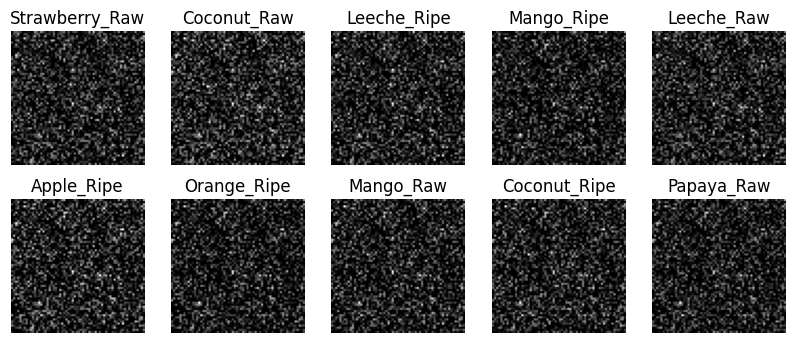

In [21]:
# Select 10 random indices
indices = np.random.choice(len(train_data.x), size=10, replace=False)
labels = train_data.get_cat_to_label()

# Sanity Check: Plot the images and their labels
plot = plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data.x[index].reshape(64, 64), cmap="gray")
    plt.title(labels[train_data.y[index]])
    plt.axis("off")
plt.show()

## **Data Preprocessing**

The data is preprocessed to remove potential outliers that could affect the performance of the classifier. The data is also standardized to have zero mean and unit variance.

### **Removing Outliers (Local Outlier Factor Algorithm)**

The `LOF` algorithm is used to remove outliers from the dataset based on their abnormally low densities. However, since the dataset is limited, the algorithm is tuned to detect only the most extreme outliers. The algorithm is run on the training data only, and the outliers are removed from the training data.

In [ ]:
lof = LOF(n_neighbors=10, contamination=0.01)
outlier_labels = lof.fit_predict(train_data.x)

print("Number of Outliers:", np.sum(outlier_labels == -1))

train_data.x = train_data.x[outlier_labels == 1]
train_data.y = train_data.y[outlier_labels == 1]

## **Standardization**

The data is standardized to have zero mean and unit variance. This is done to prevent any features from dominating the classifier. Since this project deals with an image classifier, it is all the more important to standardize the data.

In [ ]:
scaler = StandardScaler()
train_data.x = scaler.fit_transform(train_data.x)

## **Train-Test Split**

The data is split into training and test sets in a $80:20$ ratio. The training set is used to train the classifier, and the test set is used to validate the performance of the classifier.

*(**Note:** More preprocessing steps (as mentioned in the report) are utilized using a pipeline after finding the optimal hyperparameter values)*

In [3]:
x_train, x_test, y_train, y_test = train_test_split(train_data.x, train_data.y, test_size=0.20)

## **Building the Classifier using Pipeline**

The classifier is built using a pipeline. The pipeline consists of the following steps:
- (Preprocessing) Principal Component Analysis (PCA)
- (Preprocessing) Linear Discriminant Analysis (LDA)
- (Classifier) Multinomial Logistic Regression
  
The proposed pipeline is selected after multiple validations and failures of different models like $k$-NN, Random Forest, $X$-Gradient Boosting, (Gaussian) Naive Bayes, and Shallow Neural Networks.

`GridSearchCV` is used to exhaustively search for the optimal hyperparameter values for each algorithm of the pipeline. The hyperparameters are tuned by using a $5$-fold cross-validation on the training set.

In [7]:
pipe = Pipeline([
    ("pca", PCA()),
    ("lda", LDA()),
    ("lr", LogisticRegression(max_iter=10000))
])

param_grid = {
    "pca__n_components": [256, 512, 784],
    "lda__n_components": [10, 15, None],
    "lr__C": [0.1, 1, 10],
    "lr__solver": ["lbfgs", "sag"],   
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3, n_jobs=-1)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=256;, score=0.717 total time=   1.7s
[CV 3/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=256;, score=0.717 total time=   2.6s
[CV 2/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=256;, score=0.648 total time=   2.6s
[CV 4/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=256;, score=0.758 total time=   2.9s
[CV 5/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=256;, score=0.780 total time=   2.8s
[CV 2/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=512;, score=0.644 total time=   6.7s
[CV 3/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=512;, score=0.703 total time=   7.6s
[CV 1/5] END lda__n_components=10, lr__C=0.1, lr__solver=lbfgs, pca__n_components=512;, score=0.658 total

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lda', LinearDiscriminantAnalysis()),
                                       ('lr',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'lda__n_components': [10, 15, None],
                         'lr__C': [0.1, 1, 10], 'lr__solver': ['lbfgs', 'sag'],
                         'pca__n_components': [256, 512, 784]},
             verbose=3)

### **Best Hyperparameter Values**

After multiple trials, over $500+$ individual fits were performed to find the optimal hyperparameter values for the pipeline. The best hyperparameter values are shown below.

In [8]:
grid.best_params_

{'lda__n_components': None,
 'lr__C': 0.1,
 'lr__solver': 'sag',
 'pca__n_components': 256}

### **Grid Search Results**

The grid search was thoroughly evaluated before the final submission. The following cell shows the score of the "best" selected tuning of the grid on the validation set.

In [9]:
grid.score(x_test, y_test)

0.8114754098360656

## **Training the Final Classifier**

The final classifier is trained using the best hyperparameter values found above. The classifier is then used to predict the labels of the test set. 

## **Pipeline Training**

The pipeline uses the finally decided algorithms as mentioned above with the hyperparameter values returned by the grid search. The pipeline is trained on the entire training set

In [10]:
pipe = Pipeline([
    ("pca", PCA(n_components=256)),
    ("lda", LDA()),
    ("lr", LogisticRegression(max_iter=10000, C=0.1, solver="sag"))
])

pipe.fit(train_data.x, train_data.y)

Pipeline(steps=[('pca', PCA(n_components=256)),
                ('lda', LinearDiscriminantAnalysis()),
                ('lr',
                 LogisticRegression(C=0.1, max_iter=10000, solver='sag'))])

## **Predictions on Test Set**

Finally, the predictions are made on the test set using the trained pipeline. The predictions are saved in `submission.csv` file and uploaded to the Kaggle Challenge.

In [11]:
test_data = data.Dataset("test.csv")
test_data.x = scaler.transform(test_data.x)
pred = pipe.predict(test_data.x)
data.write_to_csv("submission.csv", pred, train_data.get_cat_to_label())

## **Conclusion and Results**

This attempt achieved a score of $0.82692$ on the entire test set, leading to a rank of $5$ out of $57$ teams on the leaderboard. 